The Error in Fitting Parameters (Parameter Estimation) 
==============================

Plus: Propagation of Error
=============

We've been using curve_fit to estimate the parameters of various models (the $\beta$ of an NPN bipolar junction transistor, the value of $\eta$ for an LED, and so on). In these cases we've been estimating the uncertainty in the parameters by looking at the diagonal elements of the covariance matrix (returned as the second result of the `curve_fit` function call). You may recognize code like this from project 1:

    popt, pcov = curve_fit(fitExp, data.time.values, data.voltage.values, sigma=sigma)  # do the fit

    A=popt[0]          # get the slope
    tau=popt[1]          # get the intercept

    dA = sqrt(pcov[0,0]) # uncertainty in the slope
    dTau = sqrt(pcov[1,1]) # uncertainty in the intercept
    
This method essentially assumes that the variables (A and tau) are independent and this works pretty well in many simple situations. However there is a way to achieve the same result using monto-carlo simluation that is much more robust in situations where the analytical (covariance) approach would fail. The idea is to characterize the data you have statistically. Then use a monte-carlo approach to fabricate statistally similar data to data you've collected using the same underlying model. Any non-trival interactions between the measurable quantities will also be present in the fabricated data (this is where the trouble with the cavariance matrix approach usually arises). Then you can run `curve_fit` on both the *real* and *fabricated* data. The idea is to use the variabliity in the fit parameters over the fabricated data to estimate the *uncertainty* in the parameters for the *real* data. Confused? No worries! Let's work this out with an example.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as pl
import pandas as pd                    # pandas is the "python data analysis package"
import os                              # operating system services
from scipy.optimize import curve_fit   # non-linear curve fitting

## Example: Propagation of Error

Suppose we want to measure the variation of gravity with altitude. We have a theory that gravity gets weaker as you go up higher above sea level. As an approximation we can model this as:

$$ g(y) = g_0 - a y $$

Where $g_0$ is $9.8\ {\rm m/s^2}$ and $a$ is a proportionality constant that indicates how much weaker gravity gets per meter above sea level. How to proceed? Suppose we measure $g$ at a bunch of different $y$ values and try to fit this to a curve. But wait, there's more! We don't have a "$g$ meter", we only have a ruler and a stop watch. Dang! We need to do an experiment at each value of $y$ to estimate $g(y)$ and then use that data to do the fit. OK, so onward!

How to measure "g" with a meter stick and a stopwatch.

Let's drop a ball from a height of 2m and measure how long it takes to hit the ground. According to the basic kinematics you learned in PHYS 153 that should be:

$$ h = 0.5 g t^2 $$

so

$$ t = \sqrt{\frac{2h}{g}} $$

If you're located at a place where $g=9.8\,{\rm N/kg}$ that would be:

$$ t = \sqrt{\frac{2 \cdot 2{\rm m}}{9.8\,{\rm N/kg}}} \approx 0.639\,{\rm sec}$$

Suppose we measured the time for 10 drops and get a mean of 0.64 sec with a standard error (of the mean) of 0.02 sec. Suppose further that we measure the height to within 0.5 cm. With what accuracy do we know $g$?

This problem is called "error propagation". For a single variable you'd use the slope of the functional relationship between output (g) and input (t) to find the relationahip. So, let's look at that.

$$ g = \frac{2h}{t^2} $$

so in the neighborhood of $r=0.64\,{\rm sec}$ that's:

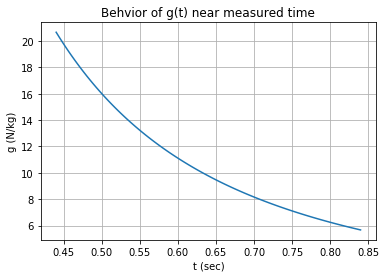

In [9]:
t=np.linspace(0.64-.2, 0.64+0.2, 100)
h=2.0

def g(t,h):
    return 2*h/t**2

pl.plot(t, g(t,h))
pl.title("Behvior of g(t) near measured time")
pl.xlabel("t (sec)")
pl.ylabel("g (N/kg)")
pl.grid()


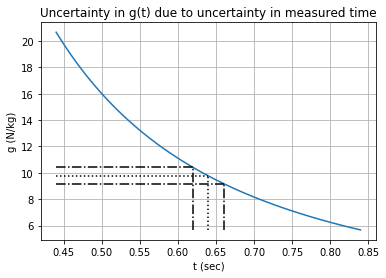

In [10]:
pl.title("Uncertainty in g(t) due to uncertainty in measured time")
pl.xlabel("t (sec)")
pl.ylabel("g (N/kg)")
pl.plot(t, g(t,h))

pl.plot((0.64-0.02,0.64-0.02), (g(t[-1],h),g(0.64-0.02,h)), 'k-.')
pl.plot((0.64+0.02,0.64+0.02), (g(t[-1],h),g(0.64+0.02,h)), 'k-.')
pl.plot((0.64,0.64), (g(t[-1],h),g(0.64,h)), 'k:')
pl.plot((t[0],0.64-0.02), (g(0.64-0.02,h),g(0.64-0.02,h)), 'k-.')
pl.plot((t[0],0.64+0.02), (g(0.64+0.02,h),g(0.64+0.02,h)), 'k-.')
pl.plot((t[0],0.64), (g(0.64,h),g(0.64,h)), 'k:')
pl.grid()



Uncertainties in the Parameters
-------------------------------

There are a variety of techniques for estimating the uncertainty in the parameters you compute. The approach we'll take is one of the more "brute force" approaches, but it's pretty robust. We're going to fabricate data that has the same statistics as our original data (do the degree that we know and/or care). Then we'll fit the fabricated data many times (1000 times in this case) and we'll look at the statistics of the fit parameters produced. From this we can tell how well our fit has done at narrowing down the parameters we computed.


In [ ]:
#
# Now do monte-carlo data fabrication and fit analysis
#

N=1000    # number of samples to take
mList=[]  # keep track of monte-carlo fit parameters
bList=[]

for i in range(N):
    """
    Generate mc data with the same statistical properties as the real data.
    Repeat the fit for each set, and record the parameters.
    """
    mcY = ystar + sigma*normal(size=len(xvals))
    mcAlpha,mcYstar,mccov = doFit([fx1,fx2],xvals,mcY,sigma)   # repeatedly fit mc data
    mList.append(mcAlpha[1])
    bList.append(mcAlpha[0])
    
#
# Compute the statistics of the mc-results
#

marr=array(mList)
barr=array(bList)

mAvg = marr.sum()/N
bAvg = barr.sum()/N
delM = marr-mAvg
delB = barr-bAvg
sigM = sqrt((delM*delM).sum()/(N-1))  # sigM is the std-deviation of the m values
sigB = sqrt((delB*delB).sum()/(N-1))  # sigB is the std-deviation of the b values

#
# plot the fit
#
print("Slope=", mFit, '+/-', sigM, "(", mFit - sigM,",",mFit + sigM, ")")
print("Intercept=", bFit, '+/-', sigB, "(", bFit - sigB,",",bFit + sigB, ")")

#
# Just for fun print out the diagonals of the covariance matrix.
#
print # print a blank link
print("Compare to cov-matrix for fun:")
print("sqsrt(cov[1,1]) (should be sigma m)", sqrt(fcov[1,1]))
print("sqrt(cov[0,0]) (should be sigma b)", sqrt(fcov[0,0]))


In [ ]:
hist(marr) # look at the variation in "m" values
print("m average:", mAvg)
print("m sigma:",sigM)

In [ ]:
hist(barr)  # look at the variation in "b" values
print("b average:", bAvg)
print("b sigma:",sigB)

In [ ]:
#
# Just to see same data fit using the non-linear scipy package "curve_fit":
#

def fLinear(x, m, b):
    return m*x + b

popt, pcov = curve_fit(fLinear, xvals, yvals, p0=(alpha[1],alpha[0]), sigma=sigma)

m=popt[0]          # slope
dm=sqrt(pcov[0,0]) # sqrt(variance(slope))
b=popt[1]          # int
db=sqrt(pcov[1,1]) # sqrt(variance(int))
ystar=fLinear(xvals, m, b)

N=1000    # number of samples to take
mList=[]  # keep track of monte-carlo fit parameters
bList=[]

for i in range(N):
    """
    Generate mc data with the same statistical properties as the real data.
    Repeat the fit for each set, and record the parameters.
    """
    mcY = ystar + sigma*normal(size=len(xvals))  # generate fabricated data to fit
    mcpopt, mcpcov = curve_fit(fLinear, xvals, mcY, p0=(m,b), sigma=sigma)
    mList.append(mcpopt[0])  # store the fit paramters for the fab-data
    bList.append(mcpopt[1])
    
#
# Compute the statistics of the mc-results
#
marr=array(mList)
barr=array(bList)

mAvg = marr.sum()/N
bAvg = barr.sum()/N
delM = marr-mAvg
delB = barr-bAvg
sigM = sqrt((delM*delM).sum()/(N-1))  # sigM is the std-deviation of the m values
sigB = sqrt((delB*delB).sum()/(N-1))  # sigB is the std-deviation of the b values

errorbar(xvals, yvals, sigma, fmt='r.') 
title("File Sizes on My HD")
ylabel("log(count)")
xlabel("log(size)")
plot(xvals,ystar, 'g-')
print("Slope=", m, '+/-', sigM, "(", m-sigM,",",m+sigM, ")")
print("Intercept=", b, '+/-', sigB, "(", b-db,",",b+sigB, ")")

print() # print a blank link
print("Compare to cov-matrix for fun:")
print("sqsrt(pcov[0,0]) (should be sigma m)", sqrt(pcov[0,0]))
print("sqrt(pcov[1,1]) (should be sigma b)", sqrt(pcov[1,1]))
